In [17]:
import pandas as pd
import glob
import os

def load_technique_data(directory):
    # Create an empty DataFrame to store data from all files
    all_data = pd.DataFrame(columns=['article_id', 'technique', 'start', 'end'])

    # Get all .txt files in the directory
    file_paths = glob.glob(os.path.join(directory, "*.task2-TC.labels"))
    if not file_paths:
        print("No files found in the directory.")
        return all_data

    # Process each file
    for file_path in file_paths:
        # Temporary list to store data for current file
        temp_data = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.strip():  # Make sure the line is not empty
                    parts = line.strip().split('\t')
                    if len(parts) == 4:  # Ensure the line has exactly four parts
                        temp_data.append(parts)
        
        # Convert the list to a DataFrame and append it to the main DataFrame
        if temp_data:
            df = pd.DataFrame(temp_data, columns=['article_id', 'technique', 'start', 'end'])
            all_data = pd.concat([all_data, df], ignore_index=True)

    # Convert start and end columns to integers
    all_data['start'] = all_data['start'].astype(int)
    all_data['end'] = all_data['end'].astype(int)

    return all_data

# Specify the directory containing the technique classification labels
directory = 'datasets/train-labels-task2-technique-classification'
technique_data = load_technique_data(directory)
print(technique_data.head())  # To check the first few entries of the data


  article_id                  technique  start   end
0  758756657                 Repetition   5024  5036
1  758756657                 Repetition   5302  5314
2  758756657            Loaded_Language     62    69
3  758756657  Causal_Oversimplification    606   746
4  758756657            Loaded_Language   4352  4361


In [18]:
# Frequency of each technique
technique_counts = technique_data['technique'].value_counts()
print("Technique Counts:\n", technique_counts)

# For co-occurrence, you can expand the earlier given script to calculate and plot these values.


Technique Counts:
 Loaded_Language                       2123
Name_Calling,Labeling                 1058
Repetition                             621
Doubt                                  493
Exaggeration,Minimisation              466
Appeal_to_fear-prejudice               294
Flag-Waving                            229
Causal_Oversimplification              209
Appeal_to_Authority                    144
Slogans                                129
Whataboutism,Straw_Men,Red_Herring     108
Black-and-White_Fallacy                107
Thought-terminating_Cliches             76
Bandwagon,Reductio_ad_hitlerum          72
Name: technique, dtype: int64


In [19]:
from itertools import combinations
from collections import Counter

def count_co_occurrences(df):
    co_occurrences = Counter()
    for article_id, group in df.groupby('article_id'):
        unique_techniques = group['technique'].unique()
        for (tech1, tech2) in combinations(unique_techniques, 2):
            if tech1 > tech2:  # Ensure consistent ordering
                tech1, tech2 = tech2, tech1
            co_occurrences[(tech1, tech2)] += 1
    return co_occurrences

# Get the co-occurrence data
co_occurrences = count_co_occurrences(technique_data)
co_occurrence_matrix = pd.Series(list(co_occurrences.values()),
                                 index=pd.MultiIndex.from_tuples(co_occurrences.keys())).unstack(fill_value=0)

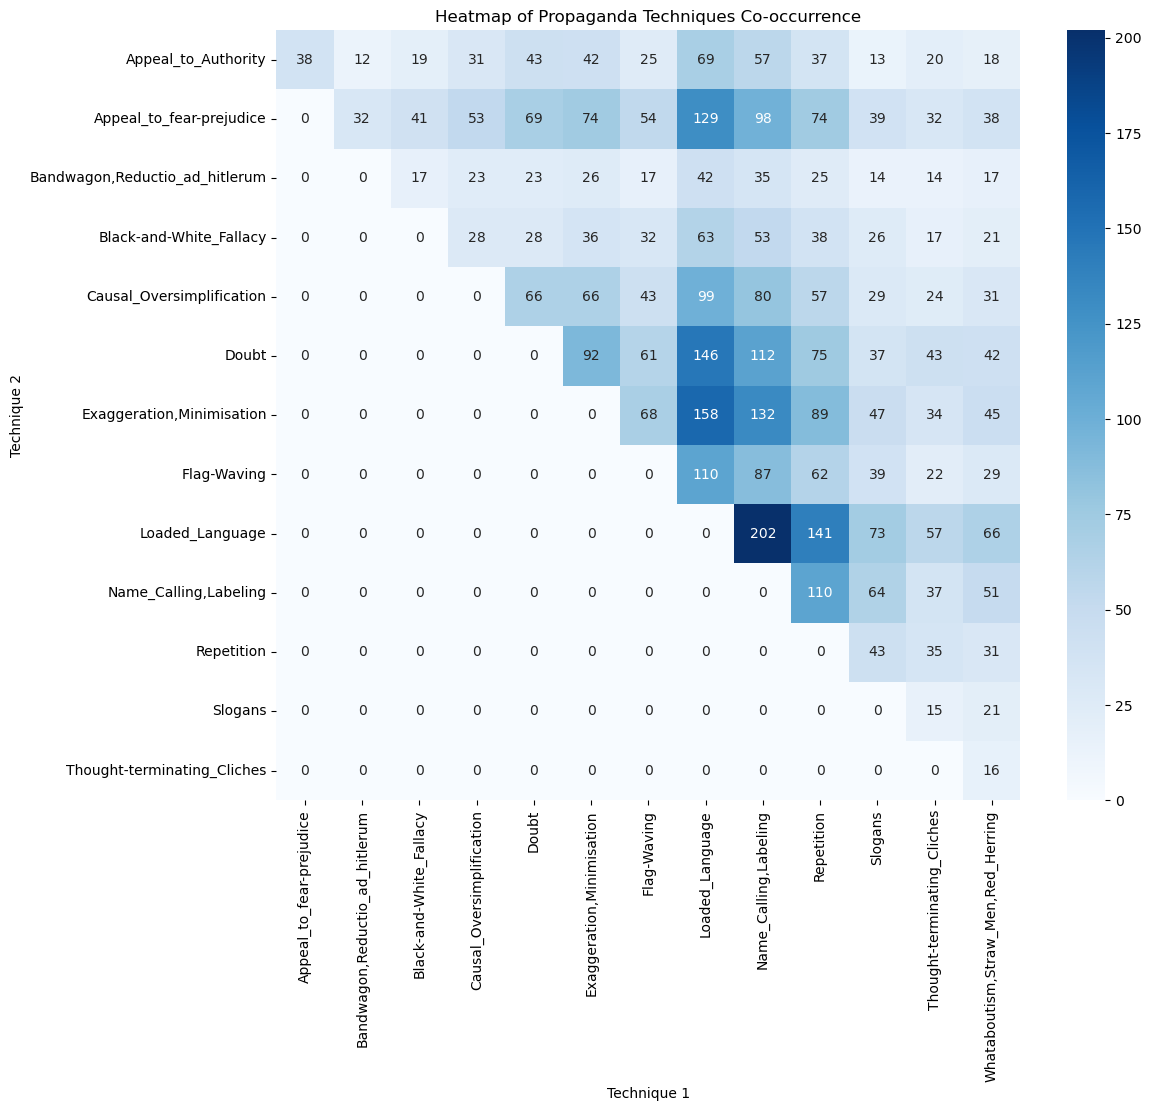

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
sns.heatmap(co_occurrence_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Heatmap of Propaganda Techniques Co-occurrence')
plt.xlabel('Technique 1')
plt.ylabel('Technique 2')
plt.show()


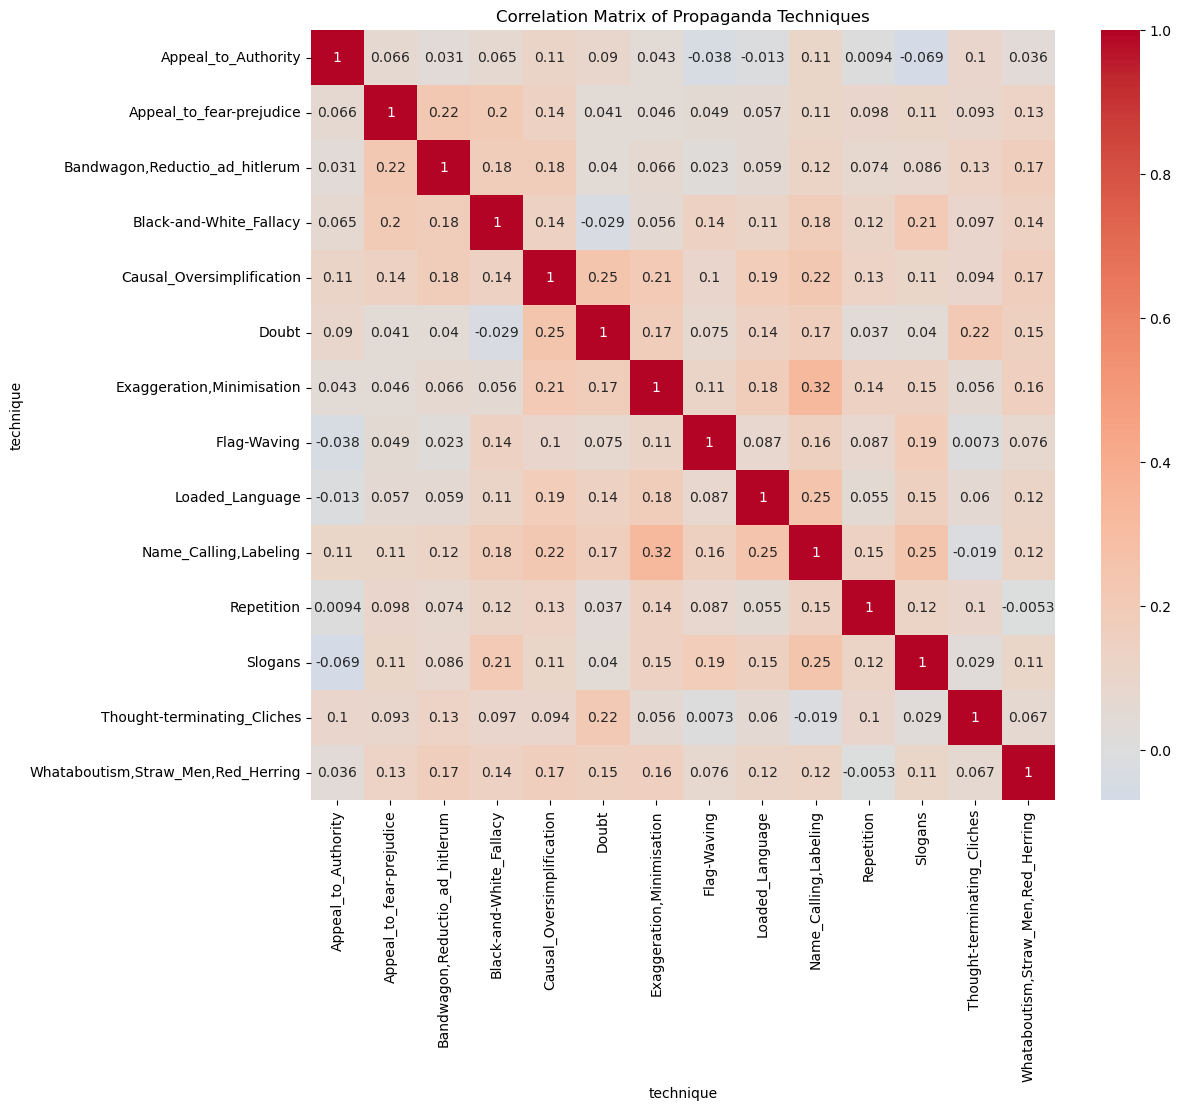

In [21]:
# Create a binary occurrence matrix (techniques by articles)
binary_occurrence = pd.pivot_table(technique_data, index='article_id', columns='technique', aggfunc='size', fill_value=0)
binary_occurrence = binary_occurrence.clip(upper=1)  # Convert counts to binary (1 if present, 0 otherwise)

# Calculate the correlation matrix
correlation_matrix = binary_occurrence.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Propaganda Techniques')
plt.show()


In [22]:
import os
import glob

def load_articles(article_folder):
    articles = {}
    file_paths = glob.glob(os.path.join(article_folder, "*.txt"))
    for file_path in file_paths:
        article_id = os.path.basename(file_path).split('.')[0].replace('article', '')
        with open(file_path, 'r', encoding='utf-8') as file:
            articles[article_id] = file.read()
    return articles

article_folder = 'datasets/train-articles'
articles = load_articles(article_folder)


In [23]:
import pandas as pd

def load_technique_data_and_texts(label_folder, articles):
    all_data = pd.DataFrame(columns=['article_id', 'technique', 'segment'])

    file_paths = glob.glob(os.path.join(label_folder, "*.task2-TC.labels"))
    for file_path in file_paths:
        article_id = os.path.basename(file_path).split('.')[0].replace('article', '')
        temp_data = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.strip():
                    parts = line.strip().split('\t')
                    if len(parts) == 4:
                        start, end = int(parts[2]), int(parts[3])
                        segment = articles[article_id][start:end]  # Extract segment from article
                        temp_data.append([article_id, parts[1], segment])
        
        if temp_data:
            df = pd.DataFrame(temp_data, columns=['article_id', 'technique', 'segment'])
            all_data = pd.concat([all_data, df], ignore_index=True)

    return all_data

label_folder = 'datasets/train-labels-task2-technique-classification'
technique_data_with_texts = load_technique_data_and_texts(label_folder, articles)
print(technique_data_with_texts.head())


  article_id                  technique  \
0  758756657                 Repetition   
1  758756657                 Repetition   
2  758756657            Loaded_Language   
3  758756657  Causal_Oversimplification   
4  758756657            Loaded_Language   

                                             segment  
0                                       Islamization  
1                                       Islamization  
2                                            outrage  
3  In order to convert to Islam, one says the sha...  
4                                          egregious  


In [24]:
# Check for any null or missing values
print(technique_data_with_texts.isnull().sum())

# Quick statistics about the dataset
print(technique_data_with_texts.describe())


article_id    0
technique     0
segment       0
dtype: int64
       article_id        technique   segment
count        6129             6129      6129
unique        357               14      5401
top     783702663  Loaded_Language  autonomy
freq          221             2123        21


In [25]:
print(technique_data_with_texts['technique'].value_counts())

Loaded_Language                       2123
Name_Calling,Labeling                 1058
Repetition                             621
Doubt                                  493
Exaggeration,Minimisation              466
Appeal_to_fear-prejudice               294
Flag-Waving                            229
Causal_Oversimplification              209
Appeal_to_Authority                    144
Slogans                                129
Whataboutism,Straw_Men,Red_Herring     108
Black-and-White_Fallacy                107
Thought-terminating_Cliches             76
Bandwagon,Reductio_ad_hitlerum          72
Name: technique, dtype: int64


In [26]:
def print_examples_by_technique(data, examples_per_technique=3):
    grouped = data.groupby('technique')
    for technique, group in grouped:
        print(f"Technique: {technique}")
        # Get a sample of texts; if less than the requested number, take as many as available
        samples = group['segment'].sample(min(len(group), examples_per_technique))
        for i, sample in enumerate(samples, 1):
            print(f"Example {i}: {sample}\n")
        print("\n")

# Call the function with the DataFrame
print_examples_by_technique(technique_data_with_texts)

Technique: Appeal_to_Authority
Example 1: is said to be

Example 2: citing church teaching through the centuries

Example 3: Sharaf ad-Din Ali Yazdi, a fifteenth-century Persian who wrote a biography of the Mongol Muslim warrior Tamerlane, observed that “the Qur’an says the highest dignity man can attain is that of making war in person against the enemies of his religion



Technique: Appeal_to_fear-prejudice
Example 1: Western Europe becomes saturated with Muslim occupants, Islamists would soon seek to stream in to his country from both Western Europe as well as from Islamic nations

Example 2: the threat Iran constitutes to US national security and interests

Example 3: The persecution of Julian Assange must end.
Or it will end in tragedy



Technique: Bandwagon,Reductio_ad_hitlerum
Example 1: who almost certainly are Soviet and Cuban communists

Example 2: If he crosses, he joins Bush II in the history books

Example 3: Unlike Stalin’s trials of the old Bolsheviks, and Fidel Castro’

In [31]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import Dataset, DataLoader
import torch
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Load the DataFrame containing your data
# Assuming it has columns 'segment' for texts and 'technique' for the label of techniques
texts = technique_data_with_texts['segment'].tolist()  # Your text data
techniques = technique_data_with_texts['technique'].tolist()  # Your label data

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(techniques)


class PropagandaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Prepare the dataset and dataloader
dataset = PropagandaDataset(texts, labels, tokenizer)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize the model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=np.unique(labels).size)
model.train()

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=1e-5)

for epoch in range(4):
    total_loss = 0
    for batch in loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {total_loss / len(loader)}')


# Optionally save the model
save_model = False  # Set this to False if you don't want to save the model
if save_model:
    model.save_pretrained('./propaganda_technique_model')
    tokenizer.save_pretrained('./propaganda_technique_model')

# Predicting with the model
model.eval()

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=512, truncation=True, padding='max_length')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1)
    return LabelEncoder().inverse_transform([prediction.cpu().numpy()[0]])[0]

# Example 
example_text = "Terrorists are planning to attack the city."
print(predict(example_text))


/Users/karthiksridhar/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/karthiksridhar/anaconda3/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


KeyboardInterrupt: 